# Simple RNN Seq2Seq

In [1]:
import os
import numpy as np
import datetime
import time

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
plt.style.use('/kaggle/input/sonia-mplstyle/sonia.mplstyle')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

PATH = '/kaggle/input/thunderstorm-data/data/'

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


## 1. Get the Data

In [3]:
class ThunderstormDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.dataset_sizes = [np.load(file_path, mmap_mode='r').shape[0] for file_path in file_paths]
        self.cumulative_sizes = np.cumsum(self.dataset_sizes)
        self.total_size = self.cumulative_sizes[-1]

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        # Find which file this idx belongs to
        file_idx = np.searchsorted(self.cumulative_sizes, idx, side='right')
        if file_idx == 0:
            within_file_idx = idx
        else:
            within_file_idx = idx - self.cumulative_sizes[file_idx - 1]
        
        file_path = self.file_paths[file_idx]
        data = np.load(file_path, mmap_mode='r')
        item = data[within_file_idx]
        
        inputs = torch.tensor(item[:6].reshape(6, -1), dtype=torch.float32)  # Flatten the first 6 images
        targets = torch.tensor(item[6:].reshape(6, -1), dtype=torch.float32)  # Flatten the last 6 images
        
        return inputs, targets

In [4]:
train_file_paths = [PATH + file for file in sorted(os.listdir(PATH))][0:40]
test_file_paths = [PATH + file for file in sorted(os.listdir(PATH))][40]

In [5]:
train_dataset = ThunderstormDataset(train_file_paths)
test_dataset = ThunderstormDataset([test_file_paths])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## 2. Create models

### 2.1. Encoders

In [6]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.5):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # [num_layers, b, hidden_size]
        out, hn = self.rnn(x, h0)  # [b, t, hidden_size]
        return out, hn  # Return the final hidden state

In [7]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.5):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        return out, (hn, cn)  # Return output and final hidden & cell states

In [8]:
class GRUEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.5):
        super(GRUEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.gru(x, h0)
        return out, hn  # Return output and final hidden state

### 2.2. Decoders

In [9]:
class RNNDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout=0.5):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_to_hidden = nn.Linear(output_size, hidden_size)

    def forward(self, x, hn):
        out, hn = self.rnn(x, hn)  # Use the hidden state from the encoder as the initial hidden state for the decoder
        out = self.fc(out)  # Map to output space
        x = self.output_to_hidden(out)
        return out, hn, x

In [10]:
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout=0.5):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_to_hidden = nn.Linear(output_size, hidden_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        x = self.output_to_hidden(out)  # Transform output to match the hidden_size
        return out, hidden, x

In [11]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout=0.5):
        super(GRUDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_to_hidden = nn.Linear(output_size, hidden_size)

    def forward(self, x, hn):
        out, hn = self.gru(x, hn)
        out = self.fc(out)
        x = self.output_to_hidden(out)  # Transform output to match the hidden_size
        return out, hn, x

### 2.3. Seq2Seq Model

In [12]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, target_seq_length):
        encoder_output, encoder_hidden = self.encoder(x)  # Encode the input sequence
        decoder_input = encoder_output[:, -1:, :]  # Use the last hidden state of encoder as the first input for decoder
        decoder_hidden = encoder_hidden

        outputs = []
        for _ in range(target_seq_length):
            decoder_output, decoder_hidden, decoder_input  = self.decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output)

        outputs = torch.cat(outputs, dim=1)  # Concatenate outputs along sequence dimension
        return outputs

## 3. Specify training loop

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = np.Inf

    def __call__(self, test_loss, model):
        score = -test_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(test_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(test_loss, model)
            self.counter = 0

    def save_checkpoint(self, test_loss, model):
        """
        Saves model when test loss decreases
        """
        self.best_loss = test_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

In [14]:
def evaluate(model, data_loader, criterion, seq_len):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, seq_len)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [15]:
def train(model, train_loader, test_loader, seq_len, num_epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        tic = time.perf_counter()
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, seq_len)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
   
        train_loss = evaluate(model, train_loader, criterion, seq_len)
        test_loss = evaluate(model, test_loader, criterion, seq_len)
        scheduler.step(test_loss)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        toc = time.perf_counter()
        sec = round(toc - tic)
        print(f"Epoch {epoch + 1:>2}/{num_epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}, Current LR: {scheduler.get_last_lr()[0]}, Time: {str(datetime.timedelta(seconds=sec))}")

        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load("checkpoint.pt"))

    return train_losses, test_losses

## 4. Initialize and train models

In [16]:
input_dim = 256 * 256
hidden_dim = 128
num_layers = 2
output_dim = 256 * 256
seq_len = 6
learning_rate = 0.001
num_epochs = 30

### 4.1. RNN

In [17]:
rnn = Seq2SeqModel(
    RNNEncoder(input_dim, hidden_dim, num_layers),
    RNNDecoder(hidden_dim, output_dim, num_layers)
).to(device)

In [18]:
train_losses, test_losses = train(rnn, train_loader, test_loader, seq_len, num_epochs, learning_rate, device)

Epoch  1/30, Train Loss: 2263.87, Test Loss: 2271.31, Current LR: 0.001, Time: 0:04:22
Epoch  2/30, Train Loss: 2251.21, Test Loss: 2261.76, Current LR: 0.001, Time: 0:03:05
Epoch  3/30, Train Loss: 2249.36, Test Loss: 2263.65, Current LR: 0.001, Time: 0:03:03
EarlyStopping counter: 1 out of 5
Epoch  4/30, Train Loss: 2238.22, Test Loss: 2250.22, Current LR: 0.001, Time: 0:02:55
Epoch  5/30, Train Loss: 2213.57, Test Loss: 2235.40, Current LR: 0.001, Time: 0:02:59
Epoch  6/30, Train Loss: 2199.00, Test Loss: 2221.19, Current LR: 0.001, Time: 0:03:09
Epoch  7/30, Train Loss: 2132.32, Test Loss: 2163.39, Current LR: 0.001, Time: 0:03:11
Epoch  8/30, Train Loss: 2087.18, Test Loss: 2128.47, Current LR: 0.001, Time: 0:03:04
Epoch  9/30, Train Loss: 2062.15, Test Loss: 2098.66, Current LR: 0.001, Time: 0:02:55
Epoch 10/30, Train Loss: 2004.41, Test Loss: 2049.39, Current LR: 0.001, Time: 0:02:57
Epoch 11/30, Train Loss: 1925.12, Test Loss: 1986.90, Current LR: 0.001, Time: 0:03:13
Epoch 12/

/tmp/ipykernel_23/2780909851.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pt"))


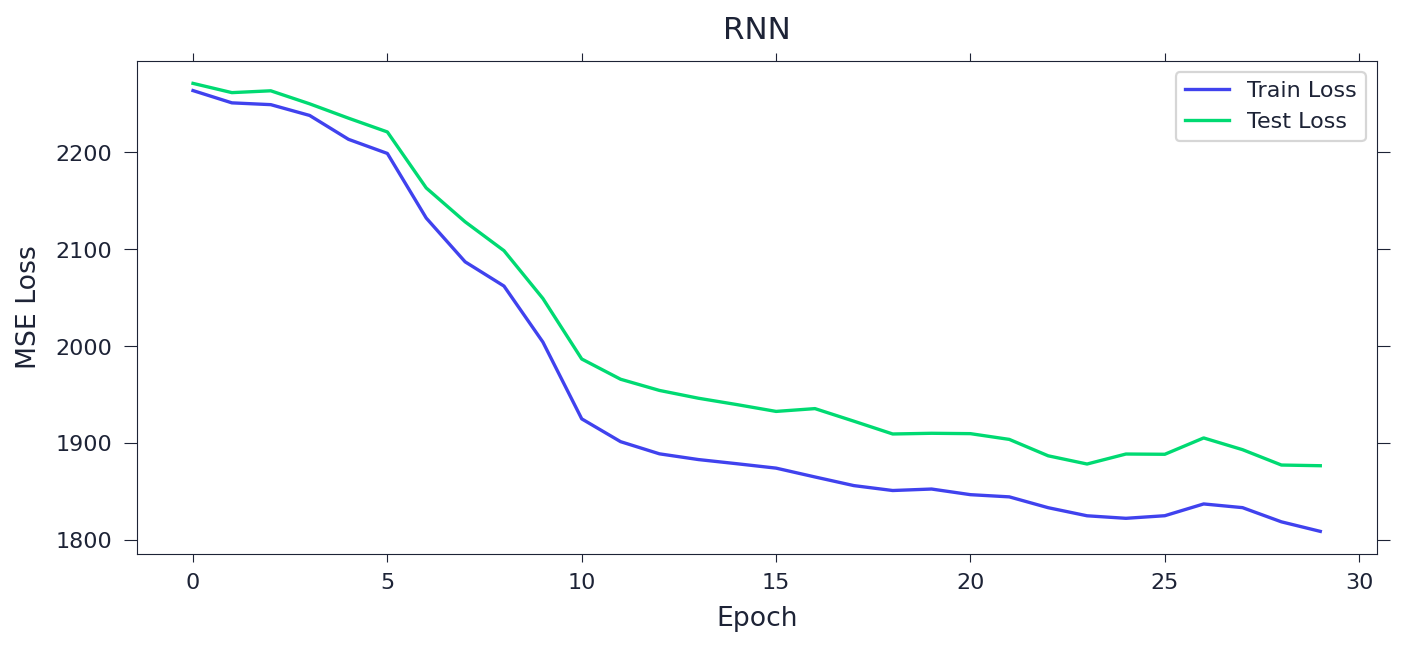

In [19]:
ax = subplots(figsize=(10, 4))[1]
ax.plot(train_losses, label='Train Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('RNN')
plt.legend();

In [20]:
criterion = nn.MSELoss()
test_loss = evaluate(rnn, test_loader, criterion, seq_len)
print(f'Test RMSE: {test_loss ** 0.5:.4f}')

Test RMSE: 43.3217


In [21]:
model_name = "RNN"
torch.save(rnn.state_dict(), f"{model_name}.pt")
np.save(f"{model_name}_train_losses.npy", np.array(train_losses))
np.save(f"{model_name}_test_losses.npy", np.array(test_losses))

### 4.2. LSTM

In [22]:
lstm = Seq2SeqModel(
    LSTMEncoder(input_dim, hidden_dim, num_layers),
    LSTMDecoder(hidden_dim, output_dim, num_layers)
).to(device)

In [23]:
train_losses, test_losses = train(lstm, train_loader, test_loader, seq_len, num_epochs, learning_rate, device)

Epoch  1/30, Train Loss: 2257.98, Test Loss: 2263.02, Current LR: 0.001, Time: 0:03:12
Epoch  2/30, Train Loss: 2242.06, Test Loss: 2257.47, Current LR: 0.001, Time: 0:03:17
Epoch  3/30, Train Loss: 2222.20, Test Loss: 2247.00, Current LR: 0.001, Time: 0:02:57
Epoch  4/30, Train Loss: 2190.51, Test Loss: 2218.49, Current LR: 0.001, Time: 0:03:12
Epoch  5/30, Train Loss: 2103.89, Test Loss: 2140.66, Current LR: 0.001, Time: 0:03:04
Epoch  6/30, Train Loss: 2017.09, Test Loss: 2072.83, Current LR: 0.001, Time: 0:02:59
Epoch  7/30, Train Loss: 1951.97, Test Loss: 2016.72, Current LR: 0.001, Time: 0:03:02
Epoch  8/30, Train Loss: 1895.17, Test Loss: 1967.08, Current LR: 0.001, Time: 0:03:18
Epoch  9/30, Train Loss: 1856.14, Test Loss: 1936.74, Current LR: 0.001, Time: 0:03:06
Epoch 10/30, Train Loss: 1816.95, Test Loss: 1890.94, Current LR: 0.001, Time: 0:03:00
Epoch 11/30, Train Loss: 1795.96, Test Loss: 1872.65, Current LR: 0.001, Time: 0:03:15
Epoch 12/30, Train Loss: 1755.47, Test Loss

/tmp/ipykernel_23/2780909851.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pt"))


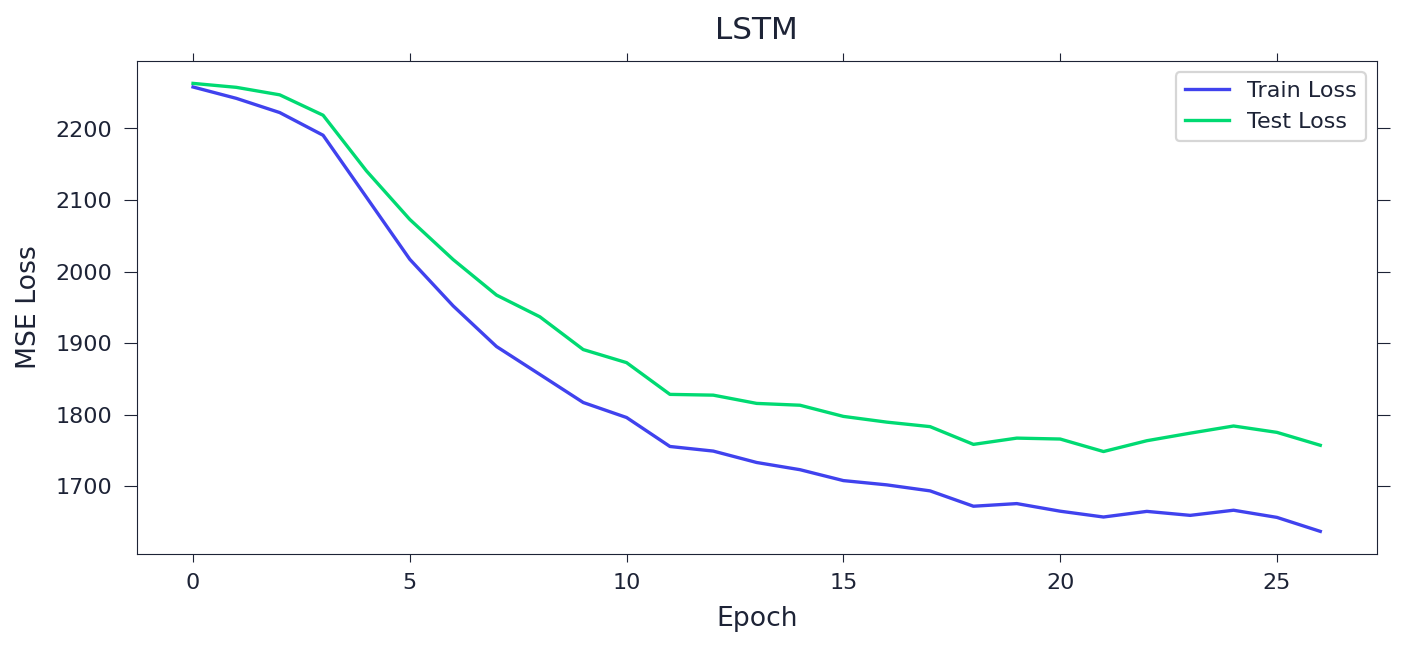

In [24]:
ax = subplots(figsize=(10, 4))[1]
ax.plot(train_losses, label='Train Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('LSTM')
plt.legend();

In [25]:
criterion = nn.MSELoss()
test_loss = evaluate(lstm, test_loader, criterion, seq_len)
print(f'Test RMSE: {test_loss ** 0.5:.4f}')

Test RMSE: 41.8138


In [26]:
model_name = "LSTM"
torch.save(lstm.state_dict(), f"{model_name}.pt")
np.save(f"{model_name}_train_losses.npy", np.array(train_losses))
np.save(f"{model_name}_test_losses.npy", np.array(test_losses))

### 4.3. GRU

In [27]:
gru = Seq2SeqModel(
    GRUEncoder(input_dim, hidden_dim, num_layers),
    GRUDecoder(hidden_dim, output_dim, num_layers)
).to(device)

In [28]:
train_losses, test_losses = train(gru, train_loader, test_loader, seq_len, num_epochs, learning_rate, device)

Epoch  1/30, Train Loss: 2256.87, Test Loss: 2263.40, Current LR: 0.001, Time: 0:02:58
Epoch  2/30, Train Loss: 2242.48, Test Loss: 2257.34, Current LR: 0.001, Time: 0:02:52
Epoch  3/30, Train Loss: 2218.14, Test Loss: 2233.36, Current LR: 0.001, Time: 0:02:52
Epoch  4/30, Train Loss: 2155.83, Test Loss: 2183.05, Current LR: 0.001, Time: 0:02:54
Epoch  5/30, Train Loss: 2070.92, Test Loss: 2107.98, Current LR: 0.001, Time: 0:03:00
Epoch  6/30, Train Loss: 1997.79, Test Loss: 2047.76, Current LR: 0.001, Time: 0:02:53
Epoch  7/30, Train Loss: 1945.28, Test Loss: 2007.42, Current LR: 0.001, Time: 0:02:53
Epoch  8/30, Train Loss: 1906.16, Test Loss: 1974.63, Current LR: 0.001, Time: 0:02:52
Epoch  9/30, Train Loss: 1878.90, Test Loss: 1954.56, Current LR: 0.001, Time: 0:03:01
Epoch 10/30, Train Loss: 1845.55, Test Loss: 1917.82, Current LR: 0.001, Time: 0:02:53
Epoch 11/30, Train Loss: 1814.41, Test Loss: 1882.22, Current LR: 0.001, Time: 0:02:53
Epoch 12/30, Train Loss: 1801.88, Test Loss

/tmp/ipykernel_23/2780909851.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pt"))


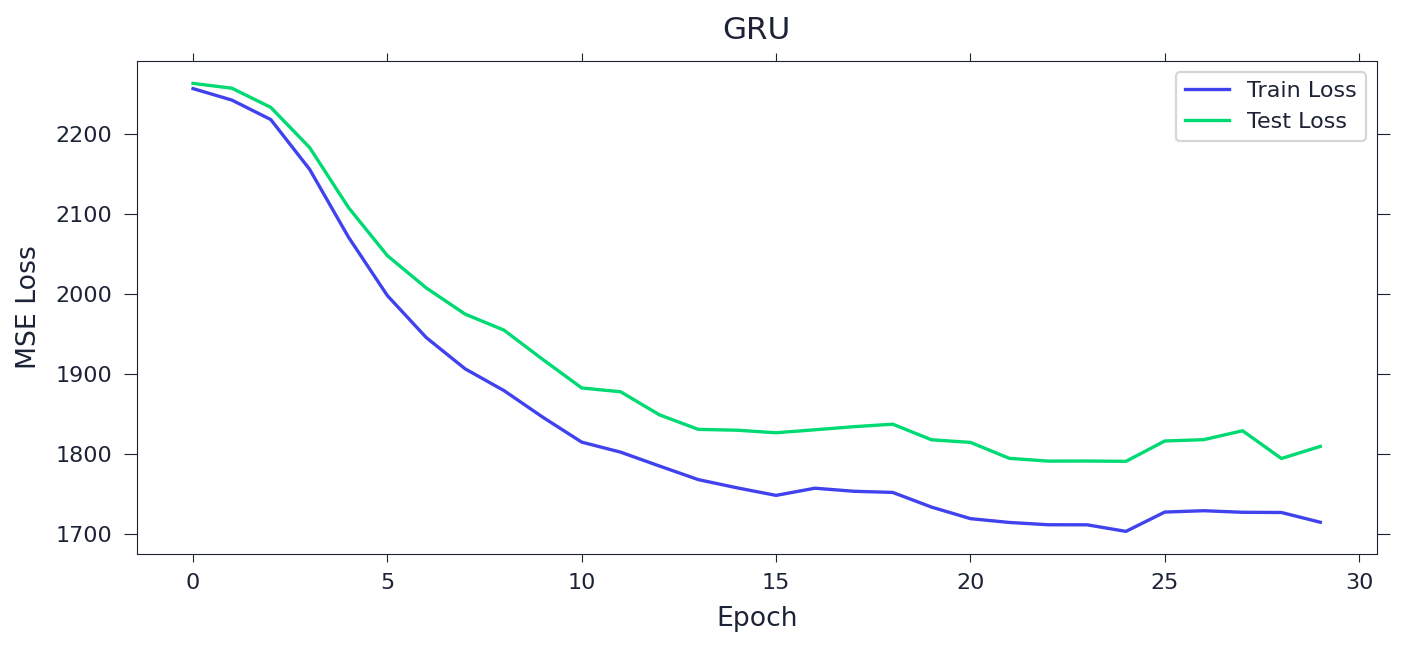

In [29]:
ax = subplots(figsize=(10, 4))[1]
ax.plot(train_losses, label='Train Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('GRU')
plt.legend();

In [30]:
criterion = nn.MSELoss()
test_loss = evaluate(gru, test_loader, criterion, seq_len)
print(f'Test RMSE: {test_loss ** 0.5:.4f}')

Test RMSE: 42.3127


In [31]:
model_name = "GRU"
torch.save(gru.state_dict(), f"{model_name}.pt")
np.save(f"{model_name}_train_losses.npy", np.array(train_losses))
np.save(f"{model_name}_test_losses.npy", np.array(test_losses))